# Naive Baseline model

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
from dateutil.parser import parse

from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('timeseries_train.csv')
df.rename(columns={"HourlyDryBulbTemperature": "temp", "datetime_beginning_utc":"Date"}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

You saw that temperature had a quadratic-looking relationship with energy usage in the previous section.
### Build a squared (quadratic) temperature variable to put into a linear regression model in the coming steps. 

In [3]:
mu_temp = df['temp'].mean()  
s_temp = df['temp'].std()
print(f"mean temp^2: {mu_temp}, stdev: {s_temp}")
df['temp2'] = (df['temp'] - mu_temp) / s_temp
df['temp2'] = df['temp2'] * df['temp2']
df.head()

mean temp^2: 53.44765187419216, stdev: 18.8704042809213


,DATE,mw,year,month,weekday,hour,temp,temp2
Date,,,,,,,,
2017-02-01 05:00:00,2017-02-01 05:00:00,1419.881,2017,2,2,5,36,0.854893
2017-02-01 06:00:00,2017-02-01 06:00:00,1379.505,2017,2,2,6,36,0.854893
2017-02-01 07:00:00,2017-02-01 07:00:00,1366.106,2017,2,2,7,34,1.062116
2017-02-01 08:00:00,2017-02-01 08:00:00,1364.453,2017,2,2,8,33,1.174152
2017-02-01 09:00:00,2017-02-01 09:00:00,1391.265,2017,2,2,9,34,1.062116


### Build an ordinary least squares (OLS) linear regression model on your training data to predict energy using the variables just described.
You will want to treat hour of day, day of week, and month of year as categorical variables.
Although it is definitely not a perfect measure of how well your model did, what is the adjusted R-squared of this model?


In [4]:
predictors = ['temp', 'temp2', 'year','month','weekday', 'hour']
outcome = 'mw'
model = LinearRegression()
model.fit(X=df.filter(items=predictors), y=df[outcome])
print(f'Intercept: {model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, model.coef_):
    print(f' {name}: {coef}')
print(f"R^2: {model.score(X=df.filter(items=predictors), y=df[outcome])}")

Intercept: 2401.674
Coefficients:
 temp: 6.190948616699035
 temp2: 138.9670578706029
 year: -0.6951036200910419
 month: 2.7245940180431867
 weekday: -18.741028627589497
 hour: 11.252808155847589
R^2: 0.44770495732079263


### Calculate the predictions (or fitted values) from your final linear regression model on your training data set. Calculate the MAPE for these predictions from your training data set.

Mean Absolute Percentage Error (MAPE)

\begin{align}
{\mbox{M}}={\frac {1}{n}}\sum _{{t=1}}^{n}\left|{\frac {A_{t}-F_{t}}{A_{t}}}\right| * 100
\end{align}


In [5]:
fitted = model.predict(df[predictors])
residuals = df[outcome] - fitted
residuals

Date
2017-02-01 05:00:00    54.324267
2017-02-01 06:00:00     2.695458
2017-02-01 07:00:00   -38.371671
2017-02-01 08:00:00   -60.655907
2017-02-01 09:00:00   -35.718287
                         ...    
2019-12-31 19:00:00   -56.674498
2019-12-31 20:00:00   -56.698307
2019-12-31 21:00:00   -29.185115
2019-12-31 22:00:00    29.499077
2019-12-31 23:00:00   -30.214146
Name: mw, Length: 25531, dtype: float64

In [6]:
tmp = np.abs(residuals / df[outcome])
tmp.shape
mape = 1/len(df)  * np.sum(tmp * 100)
mape

10.690637779488867

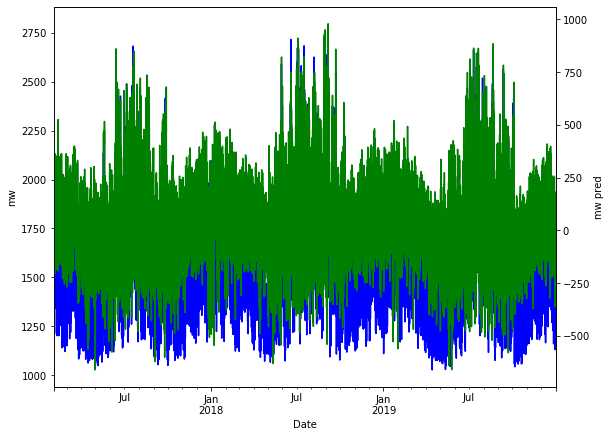

In [7]:
ax1 = df['mw'].plot(color = 'blue', figsize=(9,7))
ax1.set_ylabel('mw')
ax1.set_xlabel('Date')
ax2 = ax1.twinx()
ax2 = residuals.plot(color = 'green', figsize=(9,7))
ax2.set_ylabel('mw pred')
plt.show()

In the previous section you also noticed that temperature might have a different relationship with energy during different months of the year. 
### Plot the scatter plot between energy and temperature (as in the previous section), but only for the months of January and July.

    Compare the pattern between the months that you see here.
    It might help to overlay the plots from each month to help with this.


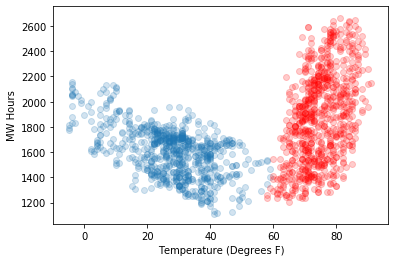

In [8]:
plt.scatter(df.query(" Date > '2019-01' and Date < '2019-02' ")['temp'], 
            df.query(" Date > '2019-01' and Date < '2019-02' ")['mw'], alpha = 0.2)
plt.scatter(df.query(" Date > '2019-07' and Date < '2019-08' ")['temp'], 
            df.query(" Date > '2019-07' and Date < '2019-08' ")['mw'], alpha = 0.2, color='r')
plt.xlabel('Temperature (Degrees F)')
plt.ylabel('MW Hours')
plt.show()

In the previous section, you also noticed that temperature might have a different relationship with energy during different times of the day. 
### Plot the scatter plot between energy and temperature (as in the previous section), but only for the hours of midnight and noon.

    Compare the pattern between the hours that you see here.
    It might help to overlay the plots from each month to help with this.


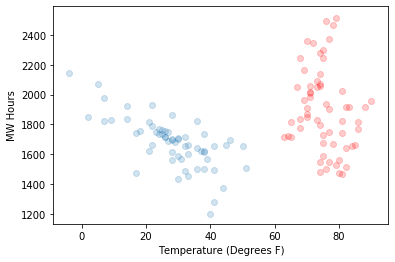

In [9]:
plt.scatter(df.query(" Date > '2019-01' and Date < '2019-02' and hour in [0,12]")['temp'], 
            df.query(" Date > '2019-01' and Date < '2019-02' and hour in [0,12]")['mw'], alpha = 0.2)
plt.scatter(df.query(" Date > '2019-07' and Date < '2019-08' and hour in [0,12]")['temp'], 
            df.query(" Date > '2019-07' and Date < '2019-08' and hour in [0,12] ")['mw'], alpha = 0.2, color='r')
plt.xlabel('Temperature (Degrees F)')
plt.ylabel('MW Hours')
plt.show()

In [10]:
# So, let us combine temp and month and temp and hour; using the scaled value to avoid multicolinearity
df['temp_norm'] = (df['temp'] - mu_temp) / s_temp
df['temp_hour'] = df['temp_norm'] * df['hour']
df['temp_month'] = df['temp_norm'] * df['month']

# predictors = ['temp', 'temp2', 'month', 'weekday', 'hour']
predictors = ['temp', 'temp2', 'year','month','weekday', 'hour', 'temp_hour', 'temp_month']
outcome = 'mw'
model = LinearRegression()
model.fit(X=df.filter(items=predictors), y=df[outcome])
print(f'Intercept: {model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, model.coef_):
    print(f' {name}: {coef}')
print(f"R^2: {model.score(X=df.filter(items=predictors), y=df[outcome])}")

Intercept: 5249.143
Coefficients:
 temp: 2.5999998468826697
 temp2: 130.76155343990072
 year: -2.022799934600962
 month: 6.1997072907467
 weekday: -18.720903427859806
 hour: 11.582061290809092
 temp_hour: 2.5489536948409457
 temp_month: 5.287751063963517
R^2: 0.45324238581831455


MAPE: 10.690545376211077


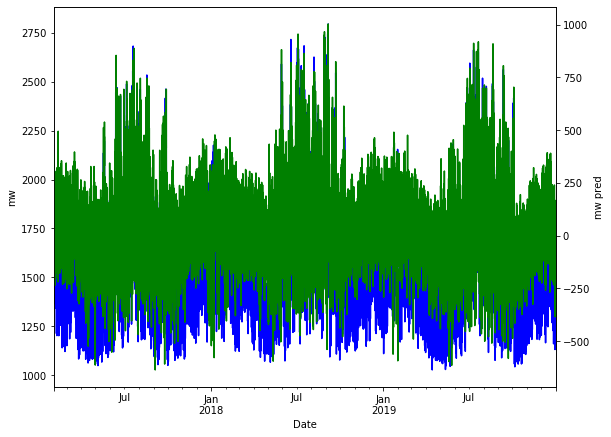

In [11]:
fitted = model.predict(df[predictors])
residuals = df[outcome] - fitted
tmp = np.abs(residuals / df[outcome]) 
mape = 1/len(df)  * np.sum(tmp * 100) 
print(f"MAPE: {mape}")
ax1 = df['mw'].plot(color = 'blue', figsize=(9,7))
ax1.set_ylabel('mw')
ax1.set_xlabel('Date')
ax2 = ax1.twinx()
ax2 = residuals.plot(color = 'green', figsize=(9,7))
ax2.set_ylabel('mw pred')
plt.show()

In [12]:
test_df = pd.read_csv('timeseries_test.csv')
test_df.rename(columns={"HourlyDryBulbTemperature": "temp", "datetime_beginning_utc":"Date"}, inplace=True)
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df = test_df.set_index('Date')
test_df['temp2'] = (test_df['temp'] - mu_temp) / s_temp
test_df['temp2'] = test_df['temp2'] * test_df['temp2']
test_df['temp_norm'] = (test_df['temp'] - mu_temp) / s_temp
test_df['temp_hour'] = test_df['temp_norm'] * test_df['hour']
test_df['temp_month'] = test_df['temp_norm'] * test_df['month']
test_df.head()

,DATE,mw,year,month,weekday,hour,temp,temp2,temp_norm,temp_hour,temp_month
Date,,,,,,,,,,,
2020-01-01 01:00:00,2020-01-01 01:00:00,1565.014,2020,1,2,1,31,1.415075,-1.189569,-1.189569,-1.189569
2020-01-01 02:00:00,2020-01-01 02:00:00,1515.905,2020,1,2,2,29,1.678463,-1.295555,-2.591111,-1.295555
2020-01-01 03:00:00,2020-01-01 03:00:00,1474.519,2020,1,2,3,30,1.543961,-1.242562,-3.727687,-1.242562
2020-01-01 04:00:00,2020-01-01 04:00:00,1421.717,2020,1,2,4,30,1.543961,-1.242562,-4.970249,-1.242562
2020-01-01 05:00:00,2020-01-01 05:00:00,1363.428,2020,1,2,5,31,1.415075,-1.189569,-5.947846,-1.189569


In [13]:
preds = model.predict(X=test_df.filter(items=predictors))
preds_df = test_df.copy()
preds_df['mw'] = preds
residuals = test_df[outcome] - preds
tmp = np.abs(residuals / test_df[outcome]) 
mape = 1/len(test_df) * np.sum(tmp * 100) 
print(f"MAPE: {mape}")
preds_df.head()

MAPE: 8.25726766297598


,DATE,mw,year,month,weekday,hour,temp,temp2,temp_norm,temp_hour,temp_month
Date,,,,,,,,,,,
2020-01-01 01:00:00,2020-01-01 01:00:00,1399.742037,2020,1,2,1,31,1.415075,-1.189569,-1.189569,-1.189569
2020-01-01 02:00:00,2020-01-01 02:00:00,1436.432307,2020,1,2,2,29,1.678463,-1.295555,-2.591111,-1.295555
2020-01-01 03:00:00,2020-01-01 03:00:00,1430.409739,2020,1,2,3,30,1.543961,-1.242562,-3.727687,-1.242562
2020-01-01 04:00:00,2020-01-01 04:00:00,1438.824567,2020,1,2,4,30,1.543961,-1.242562,-4.970249,-1.242562
2020-01-01 05:00:00,2020-01-01 05:00:00,1433.941655,2020,1,2,5,31,1.415075,-1.189569,-5.947846,-1.189569


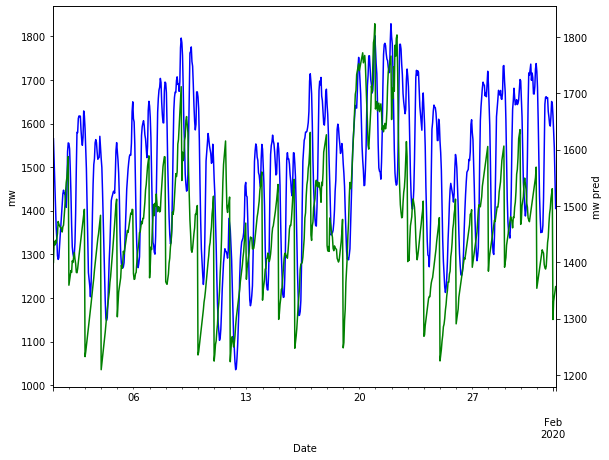

In [14]:
ax1 = test_df['mw'].plot(color = 'blue', figsize=(9,7))
ax1.set_ylabel('mw')
ax1.set_xlabel('Date')
ax2 = ax1.twinx()
ax2 = preds_df['mw'].plot(color = 'green', figsize=(9,7))
ax2.set_ylabel('mw pred')
plt.show()

###    “Forecast” out your model by scoring your test data set with the linear regression you built. Remember, we don’t want to build a model on the test data set, just run the observations through the equation we got from the training model. These are your January 2020 predictions! Plot your predicted energy values of your test data set against the actual energy values. How do you like your forecast? 